In [188]:
'''
Analysis of /r/nba Posts
@author: Brian Lin
'''
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from sklearn.linear_model import LogisticRegression

In [ ]:
def return_csv_files(path):
    pattern = r'^.*\.csv$'
    return [f for f in os.listdir(path) if bool(re.match(pattern,f))]
    
path = 'data/backlog/'
csv_files = return_csv_files(path)
df = pd.DataFrame()
for csv in csv_files:
    csv_df = pd.read_csv(path + csv)
    df = pd.concat([df,csv_df])
df['created'] = pd.to_datetime(df.created, unit = 's')

# 18,001 total examples with no duplicates

In [115]:
# top domains by value_count
top_domains = ['selfnba', 'twitter','youtube','streamable','instagram','espn','imgur','nbacom','theringer','yahoo','bleacherreport']
domain_df = pd.DataFrame()
domains = df.domain.apply(lambda d: ''.join(d.split('.')))

def strip_domain(d):
    for td in top_domains:
        if td in d:
            return td
    return 'other'


domain_df['domain'] = domains.apply(strip_domain)
domain_df['score'] = df.score
for td in top_domains:
    domain_df[td] = domains.apply(lambda d: td in d)

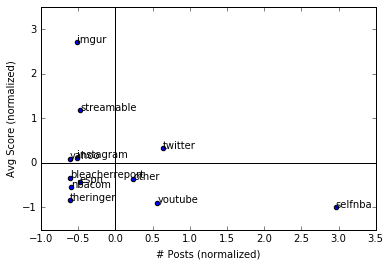

In [156]:
def normalize(column):
    mean = np.mean(column)
    sd = np.std(column)
    return column.apply(lambda d: (d-mean)/sd)

def plot_normalized_scatter(x,y,labels):
    fig, ax = plt.subplots()
    ax.scatter(x,y)
    for i, txt in enumerate(n):
        ax.annotate(txt, (x[i],y[i]))
    plt.plot([0,0], [-5,5], color='k')
    plt.plot([5,-5], [0,0], color='k')
    plt.xlim(-1, 3.5)
    plt.ylim(-1.5, 3.5)
    plt.ylabel('Avg Score (normalized)')
    plt.xlabel('# Posts (normalized)')
    

norm_domain_df = domain_df.groupby('domain').agg({'score':[np.mean,np.size]}).apply(normalize)
x = norm_domain_df['score']['size']
y = norm_domain_df['score']['mean']
n = norm_domain_df.index

plot_normalized_scatter(x,y,n)

In [186]:
def front_page_or_not(score):
    # karma >= 150 = front_page, s = 1
    # 150 > karma >= 50 = iffy, s = 0.5
    # 50 > karma = not front_page, s = 0
    if score >= 150:
        return 1
    elif score >= 50:
        return 0.5
    else:
        return 0

front_page_ser = df.score.apply(front_page_or_not)
front_page_ser.value_counts()

0.0    10985
1.0     4407
0.5     2609
Name: score, dtype: int64

In [181]:
df.score.describe()

count    18001.000000
mean       210.539970
std        548.597572
min          0.000000
25%          6.000000
50%         27.000000
75%        144.000000
max       6296.000000
Name: score, dtype: float64

0.215622450606


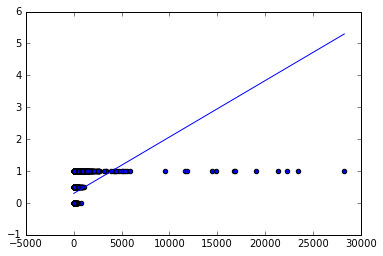

In [189]:
r = np.corrcoef(df.num_comments,front_page_ser)[0][1]
b = front_page_ser.std()/df.num_comments.std() * r
a = front_page_ser.mean() - df.num_comments.mean()*b

plt.scatter(df.num_comments, front_page_ser)
plt.plot([df.num_comments.min(),df.num_comments.max()],[df.num_comments.min()*b + a,df.num_comments.max()*b + a])
print r


model = LogisticRegression()
model.fit()